In [1]:
# Notebook to explore more serious convolutional networks 
# i.e. includes analysis of training and test accuracies

In [2]:
# Example using several models 
from core_functions import Data, Trainer, plot_train, test_accuracy
from networks import CNN_Simple, CNN_Dense
dataPath = "./second_collection_triggs_rels_32.npz"
D = Data(dataPath, triggers=True, releases=False)
D.split()
D.normalize()
D.tensors_to_device()
D.print_shapes()

End of epoch 1:loss_tr=0.652, loss_val=0.635, train=71.1%, val=71.3%
End of epoch 2:loss_tr=0.533, loss_val=0.527, train=76.5%, val=76.8%
End of epoch 3:loss_tr=0.413, loss_val=0.390, train=83.3%, val=85.3%
End of epoch 4:loss_tr=0.379, loss_val=0.357, train=85.2%, val=84.9%
End of epoch 5:loss_tr=0.340, loss_val=0.356, train=86.7%, val=85.0%
End of epoch 6:loss_tr=0.318, loss_val=0.318, train=87.4%, val=87.6%
End of epoch 7:loss_tr=0.336, loss_val=0.368, train=86.0%, val=83.5%
End of epoch 8:loss_tr=0.301, loss_val=0.293, train=88.3%, val=87.3%
End of epoch 9:loss_tr=0.327, loss_val=0.310, train=86.8%, val=87.4%
End of epoch 10:loss_tr=0.274, loss_val=0.286, train=89.7%, val=87.8%
End of epoch 11:loss_tr=0.262, loss_val=0.278, train=89.3%, val=88.2%
End of epoch 12:loss_tr=0.291, loss_val=0.310, train=87.7%, val=87.7%
End of epoch 13:loss_tr=0.269, loss_val=0.250, train=89.5%, val=89.5%
End of epoch 14:loss_tr=0.250, loss_val=0.248, train=90.1%, val=89.9%
End of epoch 15:loss_tr=0.242

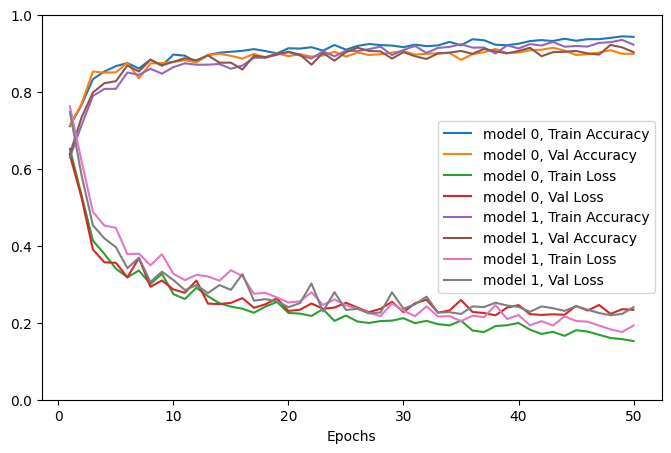

In [2]:
models = [CNN_Simple(input_ch=1, n_filters=8), CNN_Dense(input_ch=1, n_filters=8)]
trainers = [Trainer(D), Trainer(D)]
for model, T in zip(models, trainers):
    T.setup(model, max_epochs=50, batch_size=2*256)
    T.train_model(model)
plot_train(trainers)
test_accuracy(D, models)

Train, test and validation data normalized to:
[1. 1.]
[1.0011533  1.00066557]
[1.00011294 0.99422108]
Using Device:  cpu , dtype:  torch.float32

Raw data shape:  (7497, 2, 32) 
Labels shape:  (7497,) 
Unique labels:  [0 1 2] 
Shape of test set: (1125, 2, 32) 
Shape of train set: (5416, 2, 32) 
Shape of validation set: (956, 2, 32) 
Fraction of single class in test set:  0.31377777777777777 
dtype of inputs:  torch.float32


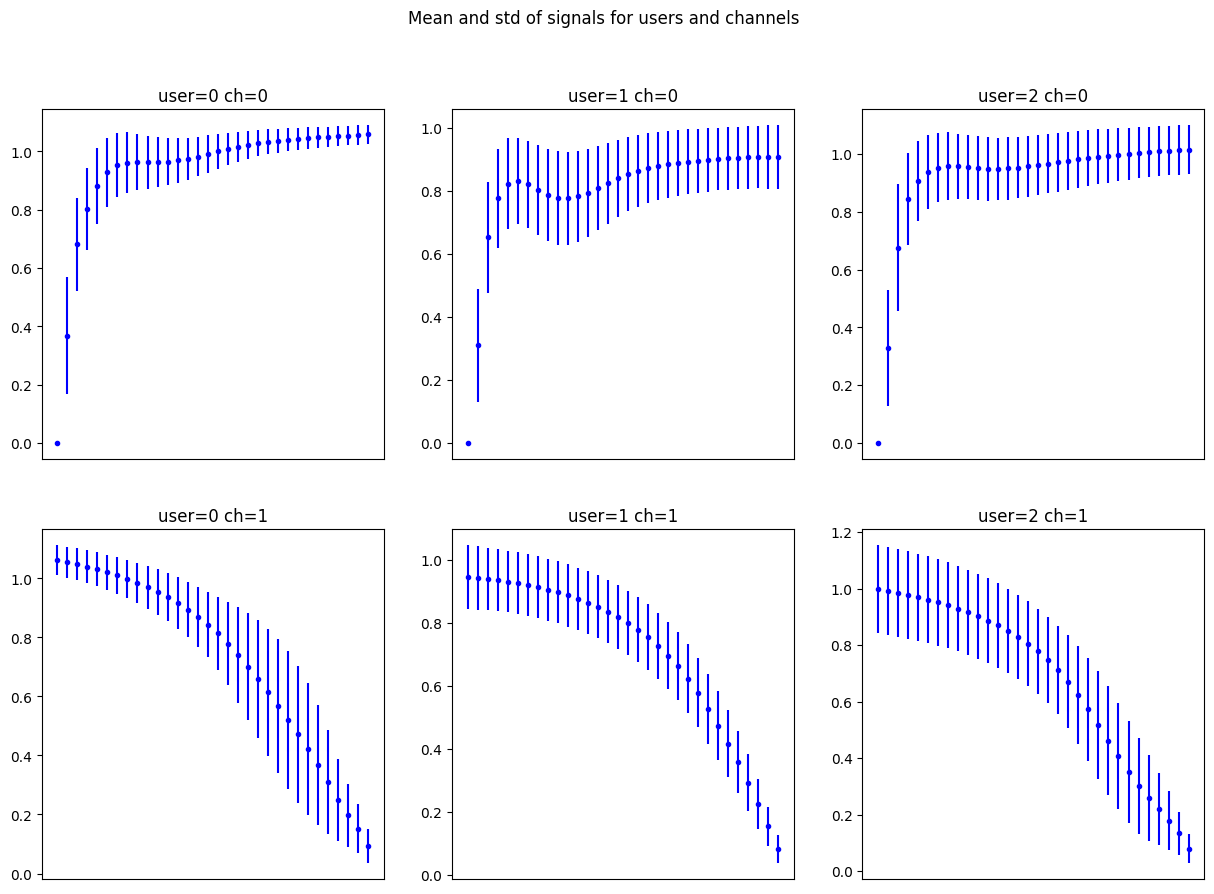

In [1]:
# Use both triggers and releases
from core_functions import Data, Trainer, plot_train, test_accuracy
from networks import CNN_Simple, CNN_Dense
dataPath = "./second_collection_triggs_rels_32.npz"
D = Data(dataPath, triggers=True, releases=True)
D.split()
D.normalize()
D.tensors_to_device()
D.print_shapes()
D.plot_data()

End of epoch 1:loss_tr=0.720, loss_val=0.749, train=64.6%, val=61.8%
End of epoch 2:loss_tr=0.571, loss_val=0.551, train=74.4%, val=74.8%
End of epoch 3:loss_tr=0.470, loss_val=0.453, train=80.5%, val=81.5%
End of epoch 4:loss_tr=0.409, loss_val=0.376, train=83.5%, val=84.0%
End of epoch 5:loss_tr=0.378, loss_val=0.348, train=84.6%, val=85.6%
End of epoch 6:loss_tr=0.358, loss_val=0.346, train=85.6%, val=87.9%
End of epoch 7:loss_tr=0.369, loss_val=0.371, train=84.7%, val=84.8%
End of epoch 8:loss_tr=0.317, loss_val=0.298, train=87.1%, val=88.0%
End of epoch 9:loss_tr=0.306, loss_val=0.297, train=87.9%, val=88.0%
End of epoch 10:loss_tr=0.303, loss_val=0.287, train=88.0%, val=89.9%
End of epoch 11:loss_tr=0.290, loss_val=0.292, train=88.3%, val=88.9%
End of epoch 12:loss_tr=0.268, loss_val=0.251, train=89.4%, val=90.5%
End of epoch 13:loss_tr=0.270, loss_val=0.269, train=89.5%, val=90.5%
End of epoch 14:loss_tr=0.265, loss_val=0.273, train=89.2%, val=87.9%
End of epoch 15:loss_tr=0.268

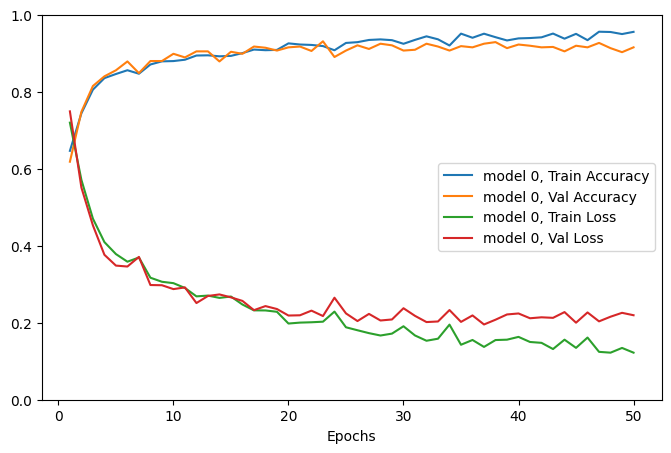

In [4]:
model = CNN_Simple(input_ch=2, n_filters=8)
T = Trainer(D)
T.setup(model, learning_rate=1e-2, weight_decay=1e-3, batch_size=2*256, max_epochs=50)
T.train_model(model)
plot_train([T])
test_accuracy(D, [model])

Train, test and validation data normalized to:
[1.]
[1.0011533]
[1.00011294]
Using Device:  cpu , dtype:  torch.float32

Raw data shape:  (7497, 1, 32) 
Labels shape:  (7497,) 
Unique labels:  [0 1 2] 
Shape of test set: (5625, 3, 32) 
Shape of train set: (27080, 3, 32) 
Shape of validation set: (4780, 3, 32) 
Fraction of single class in test set:  0.31377777777777777 
dtype of inputs:  torch.float32


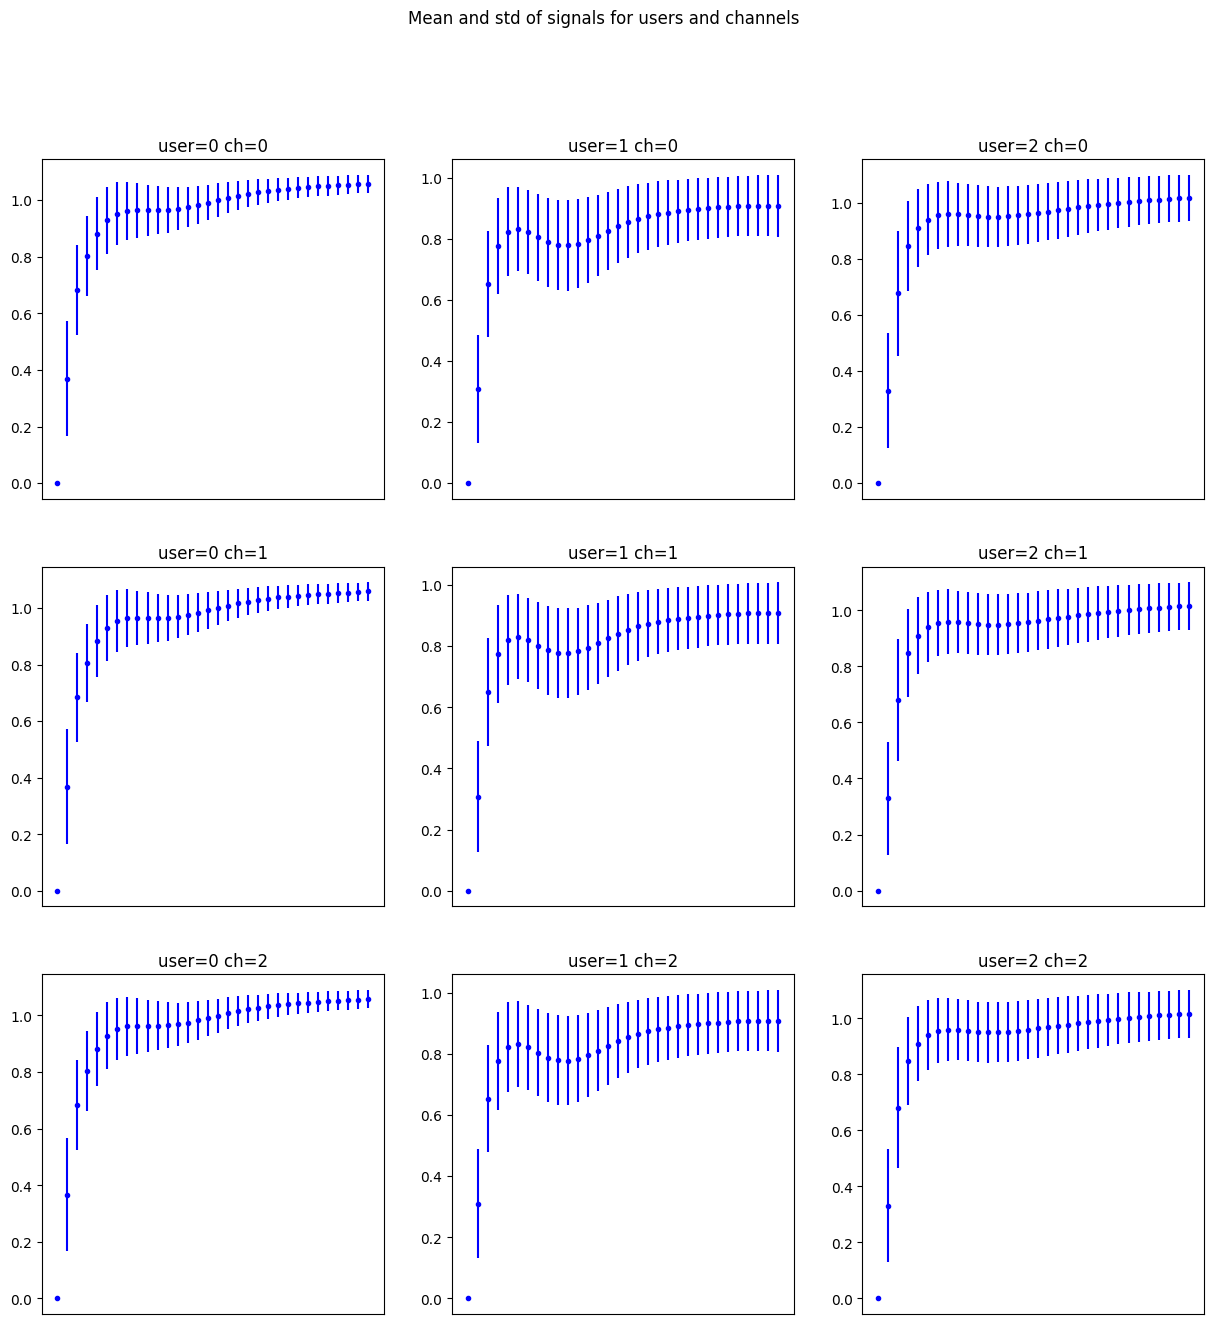

In [1]:
# Look at using several signals, one per channel
from core_functions import Data, Trainer, plot_train, test_accuracy
from networks import CNN_Simple, CNN_Dense
dataPath = "./second_collection_triggs_rels_32.npz"
D = Data(dataPath, triggers=True, releases=False)
D.split()
D.normalize()
D.resample_random_combinations()
D.tensors_to_device()
D.print_shapes()
D.plot_data()

End of epoch 1:loss_tr=0.533, loss_val=0.501, train=75.3%, val=78.2%
End of epoch 2:loss_tr=0.371, loss_val=0.340, train=84.9%, val=87.0%
End of epoch 3:loss_tr=0.278, loss_val=0.243, train=89.1%, val=91.0%
End of epoch 4:loss_tr=0.197, loss_val=0.176, train=92.8%, val=94.1%
End of epoch 5:loss_tr=0.148, loss_val=0.132, train=94.5%, val=95.5%
End of epoch 6:loss_tr=0.129, loss_val=0.123, train=95.0%, val=95.1%
End of epoch 7:loss_tr=0.104, loss_val=0.102, train=96.3%, val=96.2%
End of epoch 8:loss_tr=0.099, loss_val=0.094, train=96.3%, val=96.6%
End of epoch 9:loss_tr=0.093, loss_val=0.094, train=96.5%, val=96.4%
End of epoch 10:loss_tr=0.102, loss_val=0.109, train=96.0%, val=95.7%
End of epoch 11:loss_tr=0.083, loss_val=0.087, train=96.9%, val=96.8%
End of epoch 12:loss_tr=0.086, loss_val=0.083, train=96.8%, val=97.2%
End of epoch 13:loss_tr=0.085, loss_val=0.094, train=97.0%, val=96.5%
End of epoch 14:loss_tr=0.076, loss_val=0.077, train=97.2%, val=97.6%
End of epoch 15:loss_tr=0.076

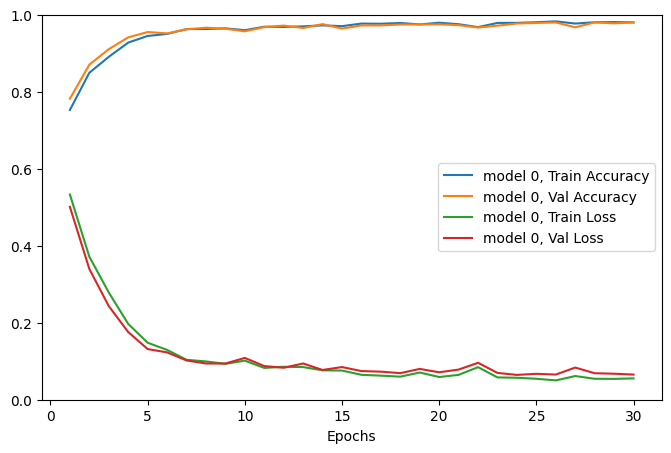

In [2]:
model = CNN_Simple(input_ch=3, n_filters=16)
T = Trainer(D)
T.setup(model, learning_rate=1e-2, weight_decay=1e-3, batch_size=2*5*256, max_epochs=30)
T.train_model(model)
plot_train([T])
test_accuracy(D, [model])

Train, test and validation data normalized to:
[1. 1.]
[1.0011533  1.00731495]
[1.00011294 1.01125842]
Using Device:  cpu , dtype:  torch.float32

Raw data shape:  (7497, 2, 32) 
Labels shape:  (7497,) 
Unique labels:  [0 1 2] 
Shape of test set: (1125, 2, 32) 
Shape of train set: (5416, 2, 32) 
Shape of validation set: (956, 2, 32) 
Fraction of single class in test set:  0.31377777777777777 
dtype of inputs:  torch.float32


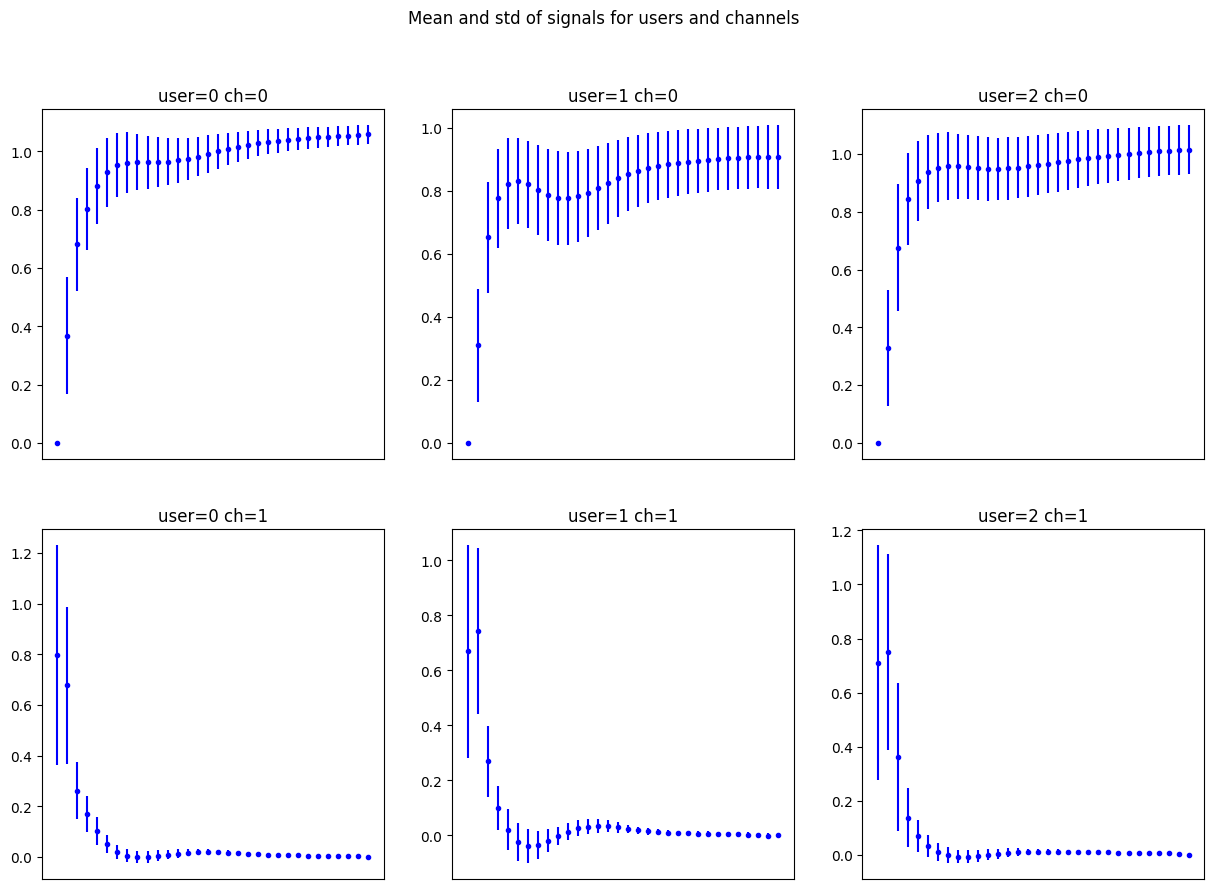

In [1]:
# Look at some simple transforms
from core_functions import Data, Trainer, plot_train, test_accuracy
from networks import CNN_Simple, CNN_Dense
dataPath = "./second_collection_triggs_rels_32.npz"
D = Data(dataPath, triggers=True, releases=False, transforms=True)
D.split()
D.normalize()
D.tensors_to_device()
D.print_shapes()
D.plot_data()

End of epoch 1:loss_tr=0.598, loss_val=0.577, train=73.1%, val=75.5%
End of epoch 2:loss_tr=0.457, loss_val=0.421, train=80.5%, val=82.8%
End of epoch 3:loss_tr=0.374, loss_val=0.332, train=84.9%, val=85.8%
End of epoch 4:loss_tr=0.327, loss_val=0.305, train=87.4%, val=86.7%
End of epoch 5:loss_tr=0.296, loss_val=0.281, train=88.7%, val=88.9%
End of epoch 6:loss_tr=0.274, loss_val=0.249, train=89.1%, val=89.7%
End of epoch 7:loss_tr=0.278, loss_val=0.275, train=89.0%, val=89.2%
End of epoch 8:loss_tr=0.278, loss_val=0.267, train=88.3%, val=88.7%
End of epoch 9:loss_tr=0.301, loss_val=0.295, train=87.7%, val=87.4%
End of epoch 10:loss_tr=0.244, loss_val=0.238, train=90.8%, val=90.5%
End of epoch 11:loss_tr=0.233, loss_val=0.222, train=91.2%, val=89.7%
End of epoch 12:loss_tr=0.259, loss_val=0.250, train=89.8%, val=89.3%
End of epoch 13:loss_tr=0.252, loss_val=0.227, train=90.5%, val=90.3%
End of epoch 14:loss_tr=0.226, loss_val=0.241, train=91.0%, val=90.9%
End of epoch 15:loss_tr=0.221

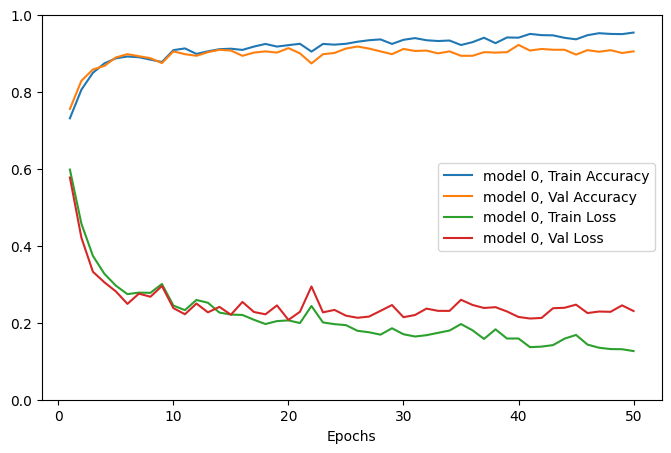

In [2]:
model = CNN_Simple(input_ch=2, n_filters=16)
T = Trainer(D)
T.setup(model, learning_rate=1e-2, weight_decay=1e-3, batch_size=2*256, max_epochs=50)
T.train_model(model)
plot_train([T])
test_accuracy(D, [model])

In [3]:
# # Longer intervals of time
from core_functions import Data, Trainer, plot_train, test_accuracy
from networks import CNN_Simple, CNN_64 
dataPath = "./second_collection_triggs_rels_64.npz"
D = Data(dataPath, triggers=True, releases=False)
D.split()
D.normalize()
D.tensors_to_device()
D.print_shapes()

Train, test and validation data normalized to:
[1.]
[0.9996899]
[0.9993976]
Using Device:  cpu , dtype:  torch.float32

Raw data shape:  (6103, 1, 64) 
Labels shape:  (6103,) 
Unique labels:  [0 1 2] 
Shape of test set: (916, 1, 64) 
Shape of train set: (4408, 1, 64) 
Shape of validation set: (779, 1, 64) 
Fraction of single class in test set:  0.38209606986899564 
dtype of inputs:  torch.float32


End of epoch 1:loss_tr=0.864, loss_val=0.889, train=59.1%, val=59.9%
End of epoch 2:loss_tr=0.744, loss_val=0.735, train=67.0%, val=67.0%
End of epoch 3:loss_tr=0.644, loss_val=0.631, train=70.9%, val=69.7%
End of epoch 4:loss_tr=0.571, loss_val=0.565, train=75.8%, val=75.6%
End of epoch 5:loss_tr=0.548, loss_val=0.537, train=75.8%, val=75.4%
End of epoch 6:loss_tr=0.503, loss_val=0.510, train=78.3%, val=79.6%
End of epoch 7:loss_tr=0.447, loss_val=0.468, train=82.2%, val=81.6%
End of epoch 8:loss_tr=0.402, loss_val=0.423, train=83.6%, val=83.2%
End of epoch 9:loss_tr=0.421, loss_val=0.444, train=81.9%, val=81.4%
End of epoch 10:loss_tr=0.384, loss_val=0.396, train=84.0%, val=84.3%
End of epoch 11:loss_tr=0.333, loss_val=0.370, train=87.0%, val=85.9%
End of epoch 12:loss_tr=0.325, loss_val=0.349, train=87.2%, val=86.5%
End of epoch 13:loss_tr=0.320, loss_val=0.343, train=86.5%, val=86.4%
End of epoch 14:loss_tr=0.273, loss_val=0.297, train=89.4%, val=88.8%
End of epoch 15:loss_tr=0.270

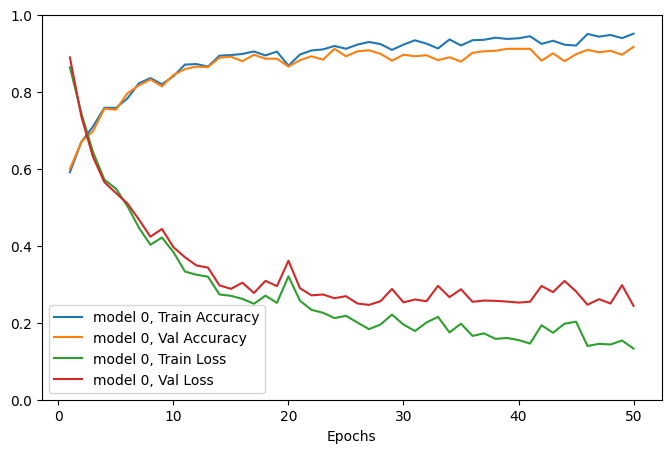

In [4]:
model = CNN_64(input_ch=1, n_filters=16)
T = Trainer(D)
T.setup(model, learning_rate=1e-2, weight_decay=1e-3, batch_size=2*256, max_epochs=50)
T.train_model(model)
plot_train([T])
test_accuracy(D, [model])